In [1]:
import bpy
import numpy as np
from pathlib import Path

# Import the blend file
blend_path = Path("hand.blend")
bpy.ops.wm.open_mainfile(filepath=str(blend_path.absolute()))

for name, obj in bpy.data.objects.items():
    print(name)

Read blend: "/home/felix/repos/felix-newman/projects/sensation-learning/hand.blend"
Hand
Szene
Окружность.001
Окружность.002
Окружность.003
Окружность.004
Окружность.005
Окружность.006


In [19]:
hand = bpy.data.objects["Hand"]


# Convert mesh to triangles
bpy.context.view_layer.objects.active = hand
bpy.ops.object.mode_set(mode='EDIT')
bpy.ops.mesh.select_all(action='SELECT')
bpy.ops.mesh.quads_convert_to_tris()
bpy.ops.object.mode_set(mode='OBJECT')

mesh = hand.data

# Get vertex coordinates and faces
vertices: list[np.ndarray] = [np.array([v.co.x, v.co.y, v.co.z]) for v in mesh.vertices]
faces: list[tuple[int, ...]] = [tuple(p.vertices) for p in mesh.polygons]

# Print coordinates of each triangle's corners


def sample_surface_points(n_points_per_face: int, faces: list[tuple[int, ...]]) -> np.ndarray:
    sensors = []
    for face in faces:
        for i in range(n_points_per_face):
            weights = np.random.random(3)
            weights /= weights.sum()

            sensor = np.array([vertices[idx] for idx in face]).T@weights
            sensors.append(sensor)

    return np.stack(sensors)




In [21]:
sensors = sample_surface_points(n_points_per_face = 10, faces=faces)


In [22]:
def gaussian_activation(center: np.ndarray, points: np.ndarray, sigma: float = 0.1) -> np.ndarray:
    """Calculate Gaussian activation values for all points relative to a center.
    
    Args:
        center: Center point coordinates of shape (2,)
        points: Array of points to evaluate, shape (N, 2)
        sigma: Width parameter of the Gaussian
        
    Returns:
        Array of activation values for each point, shape (N,)
    """
    distances = np.sum((points - center)**2, axis=1)
    return np.exp(-distances / (2 * sigma**2))

In [23]:
sensors.shape

(20480, 3)

In [24]:
%matplotlib widget


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def plot_activations_3d(activations: np.ndarray, points: np.ndarray, center: np.ndarray) -> None:
    """Plot 3D visualization of sensor activations on the hand mesh.
    
    Args:
        activations: Activation values for each point, shape (N,)
        points: 3D coordinates of points to visualize, shape (N, 3) 
        center: Coordinates of the activation center, shape (3,)
    """
    fig = plt.figure(figsize=plt.figaspect(1)*2)
    ax = fig.add_subplot(111, projection='3d')

    # Plot points colored by activation values
    scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                        c=activations, 
                        cmap='viridis',
                        s=5,
                        alpha=0.8)
    
    # Plot activation center
    ax.scatter(center[0], center[1], center[2],
              color='red',
              marker='*',
              s=200,
              label='Activation Center')

    # Add colorbar
    plt.colorbar(scatter, label='Activation Strength')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    ax.legend()

    plt.tight_layout()
    plt.show()



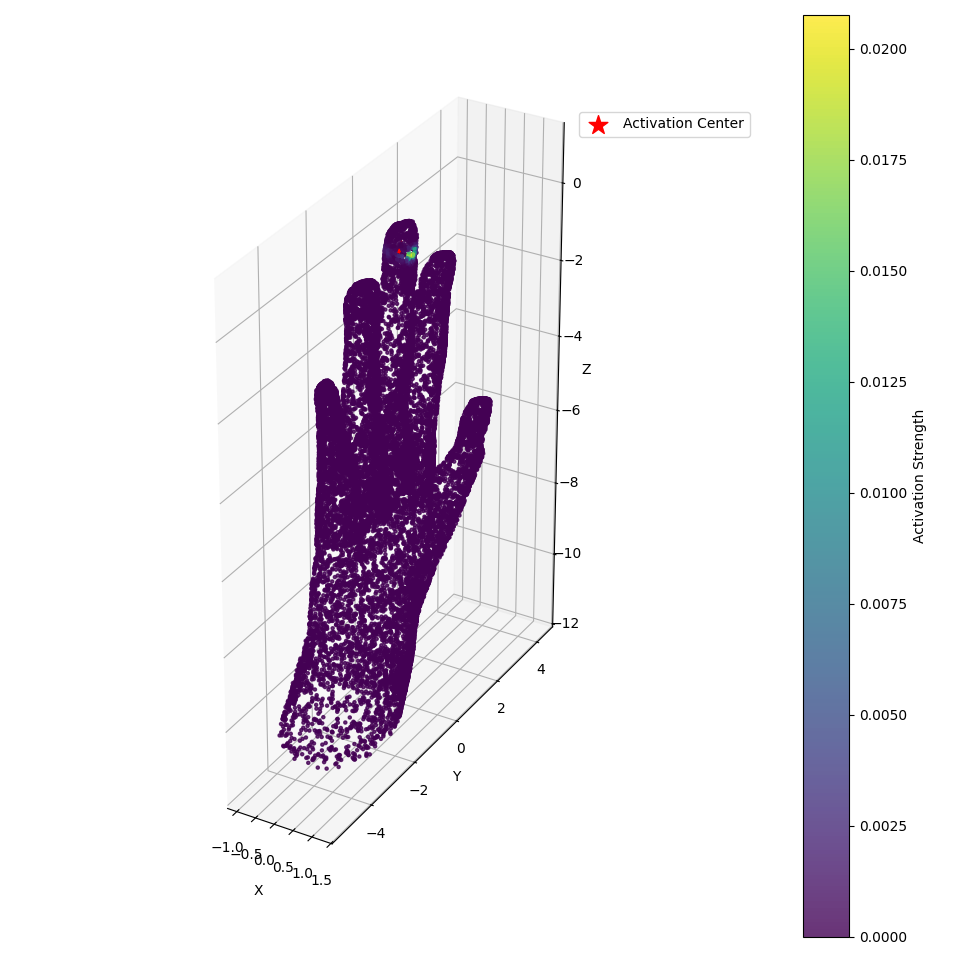

In [25]:
center = np.array([0, 0, 0])
activations = gaussian_activation(center, sensors)
plot_activations_3d(activations, sensors, center)



In [26]:
n_features_vectors = 40000
features_vectors = []
centers = sample_surface_points(n_points_per_face=n_features_vectors//len(faces), faces=faces)
for center in centers:
    features_vectors.append(gaussian_activation(center, sensors))

features_vectors = np.array(features_vectors)
features_vectors.shape

(38912, 20480)

In [29]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, random_state=42, perplexity=30.0)
embedding = tsne.fit_transform(features_vectors)
embedding.shape

print(f"KL divergence: {tsne.kl_divergence_}")

KL divergence: 1.1168190240859985


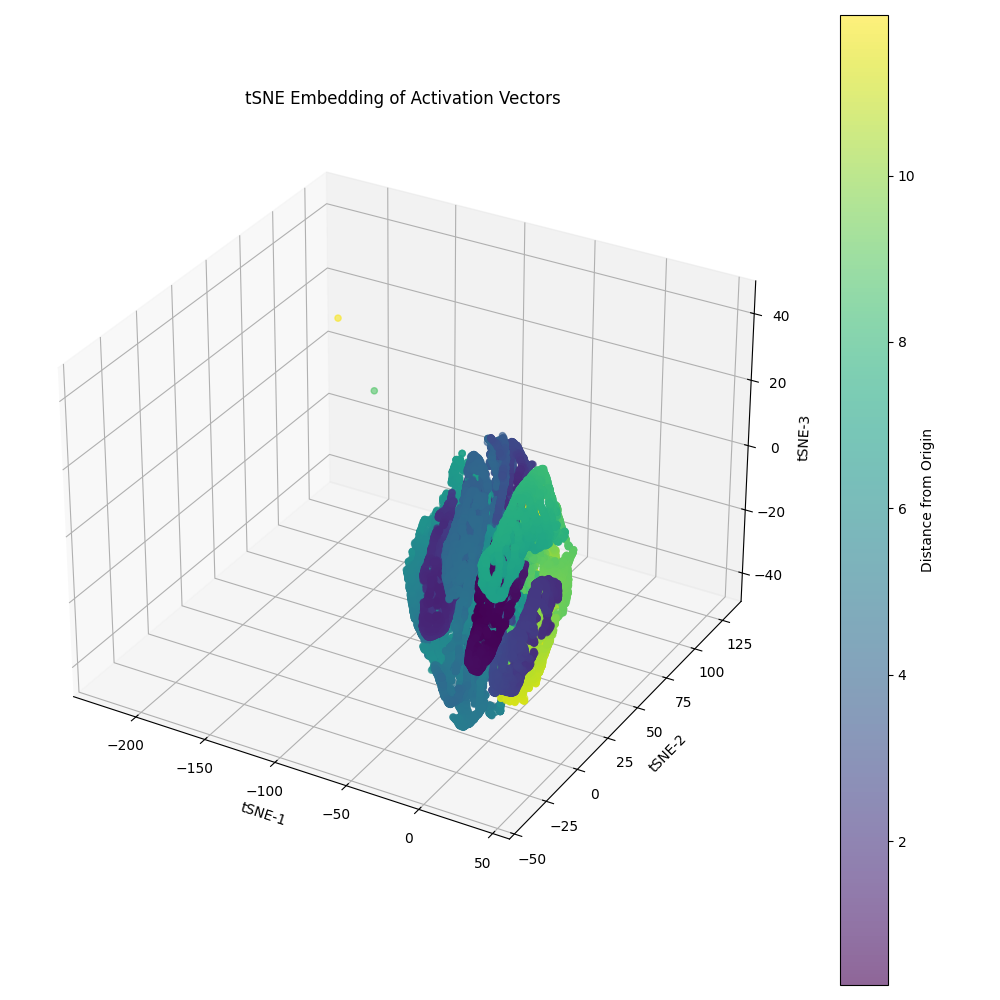

In [30]:
# Create 3D scatter plot of embeddings
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(embedding[:, 0], 
                    embedding[:, 1], 
                    embedding[:, 2],
                    c=np.linalg.norm(centers, axis=1),  # Color by distance from origin
                    cmap='viridis',
                    alpha=0.6)

ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2') 
ax.set_zlabel('tSNE-3')
ax.set_title('tSNE Embedding of Activation Vectors')

plt.colorbar(scatter, label='Distance from Origin')
plt.tight_layout()
plt.show()
